<a href="https://www.kaggle.com/code/mohammedmohsen0404/english-french-neural-machine-translation?scriptVersionId=198314571" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

---
**<center><h1>English-French Neural Machine Translation</h1></center>**
<center><h3>Learning ML, DL through 100 Practical Projects</h3></center>

---

The aim of this project is to build a Neural Machine Translation (NMT) model using a vanilla sequence-to-sequence (seq2seq) architecture with LSTM layers to translate English sentences into French. The project focuses on developing a model capable of understanding and generating syntactically correct and contextually appropriate translations between the two languages.

![Vanilla seq2seq](https://d3i71xaburhd42.cloudfront.net/673fa8ca55db79acdd88d50b465ec4580166fe09/2-Figure1-1.png)

# **Import Libraries and Data**
---

In [1]:
import pandas as pd
import numpy as np
import string
from string import digits
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re
from sklearn.model_selection import train_test_split

from keras.layers import Input, LSTM, Embedding, Dense, Bidirectional, Concatenate, Dot, Activation, TimeDistributed
from keras.models import Model
from keras.utils import plot_model

In [2]:
!wget http://www.manythings.org/anki/fra-eng.zip
!unzip fra-eng.zip -d fra-eng

--2024-09-26 03:55:17--  http://www.manythings.org/anki/fra-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7943074 (7.6M) [application/zip]
Saving to: 'fra-eng.zip'

fra-eng.zip         100%[===================>]   7.57M  6.37MB/s    in 1.2s    

2024-09-26 03:55:19 (6.37 MB/s) - 'fra-eng.zip' saved [7943074/7943074]

Archive:  fra-eng.zip
  inflating: fra-eng/_about.txt      
  inflating: fra-eng/fra.txt         


# **Data Preparing**
---

In [3]:
data_path = 'fra-eng/fra.txt'
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')

lines[:5]

['Go.\tVa !\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1158250 (Wittydev)',
 'Go.\tMarche.\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8090732 (Micsmithel)',
 'Go.\tEn route !\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8267435 (felix63)',
 'Go.\tBouge !\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #9022935 (Micsmithel)',
 'Hi.\tSalut !\tCC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #509819 (Aiji)']

In [4]:
inputs = []
targets = []
num_samples = 100000  # Number of samples to train on.
for line in lines[: min(num_samples, len(lines) - 1)]:
  input, target, _ = line.split('\t')
  inputs.append(input)
  targets.append(target)

print(inputs [:5])
print(targets[:5])

['Go.', 'Go.', 'Go.', 'Go.', 'Hi.']
['Va !', 'Marche.', 'En route !', 'Bouge !', 'Salut !']


In [5]:
lines = pd.DataFrame({'input':inputs, 'target':targets})
num_samples = 10000
lines = lines[0:num_samples]
lines.shape

(10000, 2)

In [6]:
lines.head(10)

,input,target
0,Go.,Va !
1,Go.,Marche.
2,Go.,En route !
3,Go.,Bouge !
4,Hi.,Salut !
5,Hi.,Salut.
6,Run!,Cours !
7,Run!,Courez !
8,Run!,Prenez vos jambes à vos cous !
9,Run!,File !


In [7]:
def cleanup(lines):
  # Since we work on word level, if we normalize the text to lower case, this will reduce the vocabulary. It's easy to recover the case later.
  lines.input=lines.input.apply(lambda x: x.lower())
  lines.target=lines.target.apply(lambda x: x.lower())

  # To help the model capture the word separations, mark the comma with special token:
  lines.input=lines.input.apply(lambda x: re.sub("'", '', x)).apply(lambda x: re.sub(",", ' COMMA', x))
  lines.target=lines.target.apply(lambda x: re.sub("'", '', x)).apply(lambda x: re.sub(",", ' COMMA', x))

  # Clean up punctuations and digits. Such special chars are common to both domains, and can just be copied with no error.
  exclude = set(string.punctuation)
  lines.input=lines.input.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
  lines.target=lines.target.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))

  remove_digits = str.maketrans('', '', digits)
  lines.input=lines.input.apply(lambda x: x.translate(remove_digits))
  lines.target=lines.target.apply(lambda x: x.translate(remove_digits))

  #return lines


In [8]:
st_tok = 'START_'
end_tok = '_END'
def data_prep(lines):
  cleanup(lines)
  lines.target = lines.target.apply(lambda x : st_tok + ' ' + x + ' ' + end_tok)

In [9]:
data_prep(lines)
lines.head(20)

,input,target
0,go,START_ va _END
1,go,START_ marche _END
2,go,START_ en route _END
3,go,START_ bouge _END
4,hi,START_ salut _END
5,hi,START_ salut _END
6,run,START_ cours _END
7,run,START_ courez _END
8,run,START_ prenez vos jambes à vos cous _END
9,run,START_ file _END


# **Data Preprocessing**
--------

**Tokenization**

In [10]:
def tok_split_word2word(data):
    return data.split()

def data_stats(lines, input_tok_split_fn, target_tok_split_fn):
    # Get unique tokens using set comprehensions
    input_tokens = set(tok for line in lines.input for tok in input_tok_split_fn(line))
    target_tokens = set(tok for line in lines.target for tok in target_tok_split_fn(line))

    # Convert to sorted lists
    input_tokens = sorted(input_tokens)
    target_tokens = sorted(target_tokens)

    # Calculate lengths
    num_encoder_tokens = len(input_tokens)
    num_decoder_tokens = len(target_tokens)
    max_encoder_seq_length = max(len(input_tok_split_fn(line)) for line in lines.input)
    max_decoder_seq_length = max(len(target_tok_split_fn(line)) for line in lines.target)

    return (input_tokens, target_tokens, num_encoder_tokens,num_decoder_tokens, max_encoder_seq_length, max_decoder_seq_length)

In [11]:
input_tokens, target_tokens, num_encoder_tokens, num_decoder_tokens, max_encoder_seq_length, max_decoder_seq_length = data_stats(
    lines, input_tok_split_fn=tok_split_word2word, target_tok_split_fn=tok_split_word2word)

print('Number of samples:', len(lines))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 10000
Number of unique input tokens: 2022
Number of unique output tokens: 4412
Max sequence length for inputs: 5
Max sequence length for outputs: 12


**Vocab**

In [12]:
pad_tok = 'PAD'
sep_tok = ' '
special_tokens = [pad_tok, sep_tok, st_tok, end_tok]
num_encoder_tokens += len(special_tokens)
num_decoder_tokens += len(special_tokens)

In [13]:
def vocab(input_tokens, target_tokens):

  input_token_index = {}
  target_token_index = {}
  for i,tok in enumerate(special_tokens):
    input_token_index[tok] = i
    target_token_index[tok] = i

  offset = len(special_tokens)
  for i, tok in enumerate(input_tokens):
    input_token_index[tok] = i+offset

  for i, tok in enumerate(target_tokens):
    target_token_index[tok] = i+offset

  # Reverse-lookup token index to decode sequences back to something readable.
  reverse_input_tok_index = dict(
      (i, tok) for tok, i in input_token_index.items())
  reverse_target_tok_index = dict(
      (i, tok) for tok, i in target_token_index.items())
  return input_token_index, target_token_index, reverse_input_tok_index, reverse_target_tok_index

In [14]:
input_token_index, target_token_index, reverse_input_tok_index, reverse_target_tok_index = vocab(input_tokens, target_tokens)

**Vectorization**

In [15]:
max_encoder_seq_length = 16
max_decoder_seq_length = 16

In [16]:
def init_model_inputs(lines, max_encoder_seq_length, max_decoder_seq_length, num_decoder_tokens):
  encoder_input_data = np.zeros(
      (len(lines.input), max_encoder_seq_length),
      dtype='float32')
  decoder_input_data = np.zeros(
      (len(lines.target), max_decoder_seq_length),
      dtype='float32')
  decoder_target_data = np.zeros(
      (len(lines.target), max_decoder_seq_length, num_decoder_tokens),
      dtype='float32')

  return encoder_input_data, decoder_input_data, decoder_target_data

In [17]:
def vectorize(lines, max_encoder_seq_length, max_decoder_seq_length, num_decoder_tokens, input_tok_split_fn, target_tok_split_fn):
  encoder_input_data, decoder_input_data, decoder_target_data = init_model_inputs(lines, max_encoder_seq_length, max_decoder_seq_length, num_decoder_tokens)
  for i, (input_text, target_text) in enumerate(zip(lines.input, lines.target)):
      for t, tok in enumerate(input_tok_split_fn(input_text)):
          encoder_input_data[i, t] = input_token_index[tok]
      encoder_input_data[i, t+1:] = input_token_index[pad_tok]
      for t, tok in enumerate(target_tok_split_fn(target_text)):
          # decoder_target_data is ahead of decoder_input_data by one timestep
          decoder_input_data[i, t] = target_token_index[tok]
          if t > 0:
              # decoder_target_data will be ahead by one timestep
              # and will not include the start character.
              decoder_target_data[i, t - 1, target_token_index[tok]] = 1.
      decoder_input_data[i, t+1:] = target_token_index[pad_tok]
      decoder_target_data[i, t:, target_token_index[pad_tok]] = 1.

  return encoder_input_data, decoder_input_data, decoder_target_data

In [18]:
encoder_input_data, decoder_input_data, decoder_target_data  = vectorize(lines, max_encoder_seq_length, max_decoder_seq_length, num_decoder_tokens, input_tok_split_fn=tok_split_word2word, target_tok_split_fn=tok_split_word2word)

In [19]:
encoder_input_data.shape, decoder_input_data.shape, decoder_target_data.shape

((10000, 16), (10000, 16), (10000, 16, 4416))

# **Modelling**

In [20]:
def seq2seq(num_decoder_tokens, num_encoder_tokens, emb_sz, lstm_sz):
    # Encoder
    encoder_inputs = Input(shape=(None,))
    en_x = Embedding(num_encoder_tokens, emb_sz, mask_zero=True)(encoder_inputs)
    encoder = LSTM(lstm_sz, return_state=True)
    encoder_outputs, state_h, state_c = encoder(en_x)
    encoder_states = [state_h, state_c]

    # Encoder model
    encoder_model = Model(encoder_inputs, encoder_states)

    # Decoder
    decoder_inputs = Input(shape=(None,))
    dex = Embedding(num_decoder_tokens, emb_sz, mask_zero=True)(decoder_inputs)

    decoder_lstm = LSTM(lstm_sz, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(dex, initial_state=encoder_states)

    decoder_dense = Dense(num_decoder_tokens, activation='softmax')
    decoder_outputs = decoder_dense(decoder_outputs)

    # Full model
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

    # Decoder model for inference
    decoder_state_input_h = Input(shape=(lstm_sz,))
    decoder_state_input_c = Input(shape=(lstm_sz,))
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

    decoder_outputs2, state_h2, state_c2 = decoder_lstm(dex, initial_state=decoder_states_inputs)
    decoder_states2 = [state_h2, state_c2]
    decoder_outputs2 = decoder_dense(decoder_outputs2)
    decoder_model = Model(
        [decoder_inputs] + decoder_states_inputs,
        [decoder_outputs2] + decoder_states2
    )

    return model, encoder_model, decoder_model


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, None, 256) │    518,656 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, None)      │          0 │ input_layer[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, None, 256) │  1,130,496 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 256),     │    525,312 │ embedding[0][0],  │
│                     │ (None, 256),      │            │ not_equal[0][0]   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, None,     │    525,312 │ embedding_1[0][0… │
│                     │ 256), (None,      │            │ lstm[0][1],       │
│                     │ 256), (None,      │            │ lstm[0][2]        │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, None,      │  1,134,912 │ lstm_1[0][0]      │
│                     │ 4416)             │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,834,688 (14.63 MB)

 Trainable params: 3,834,688 (14.63 MB)

 Non-trainable params: 0 (0.00 B)

None


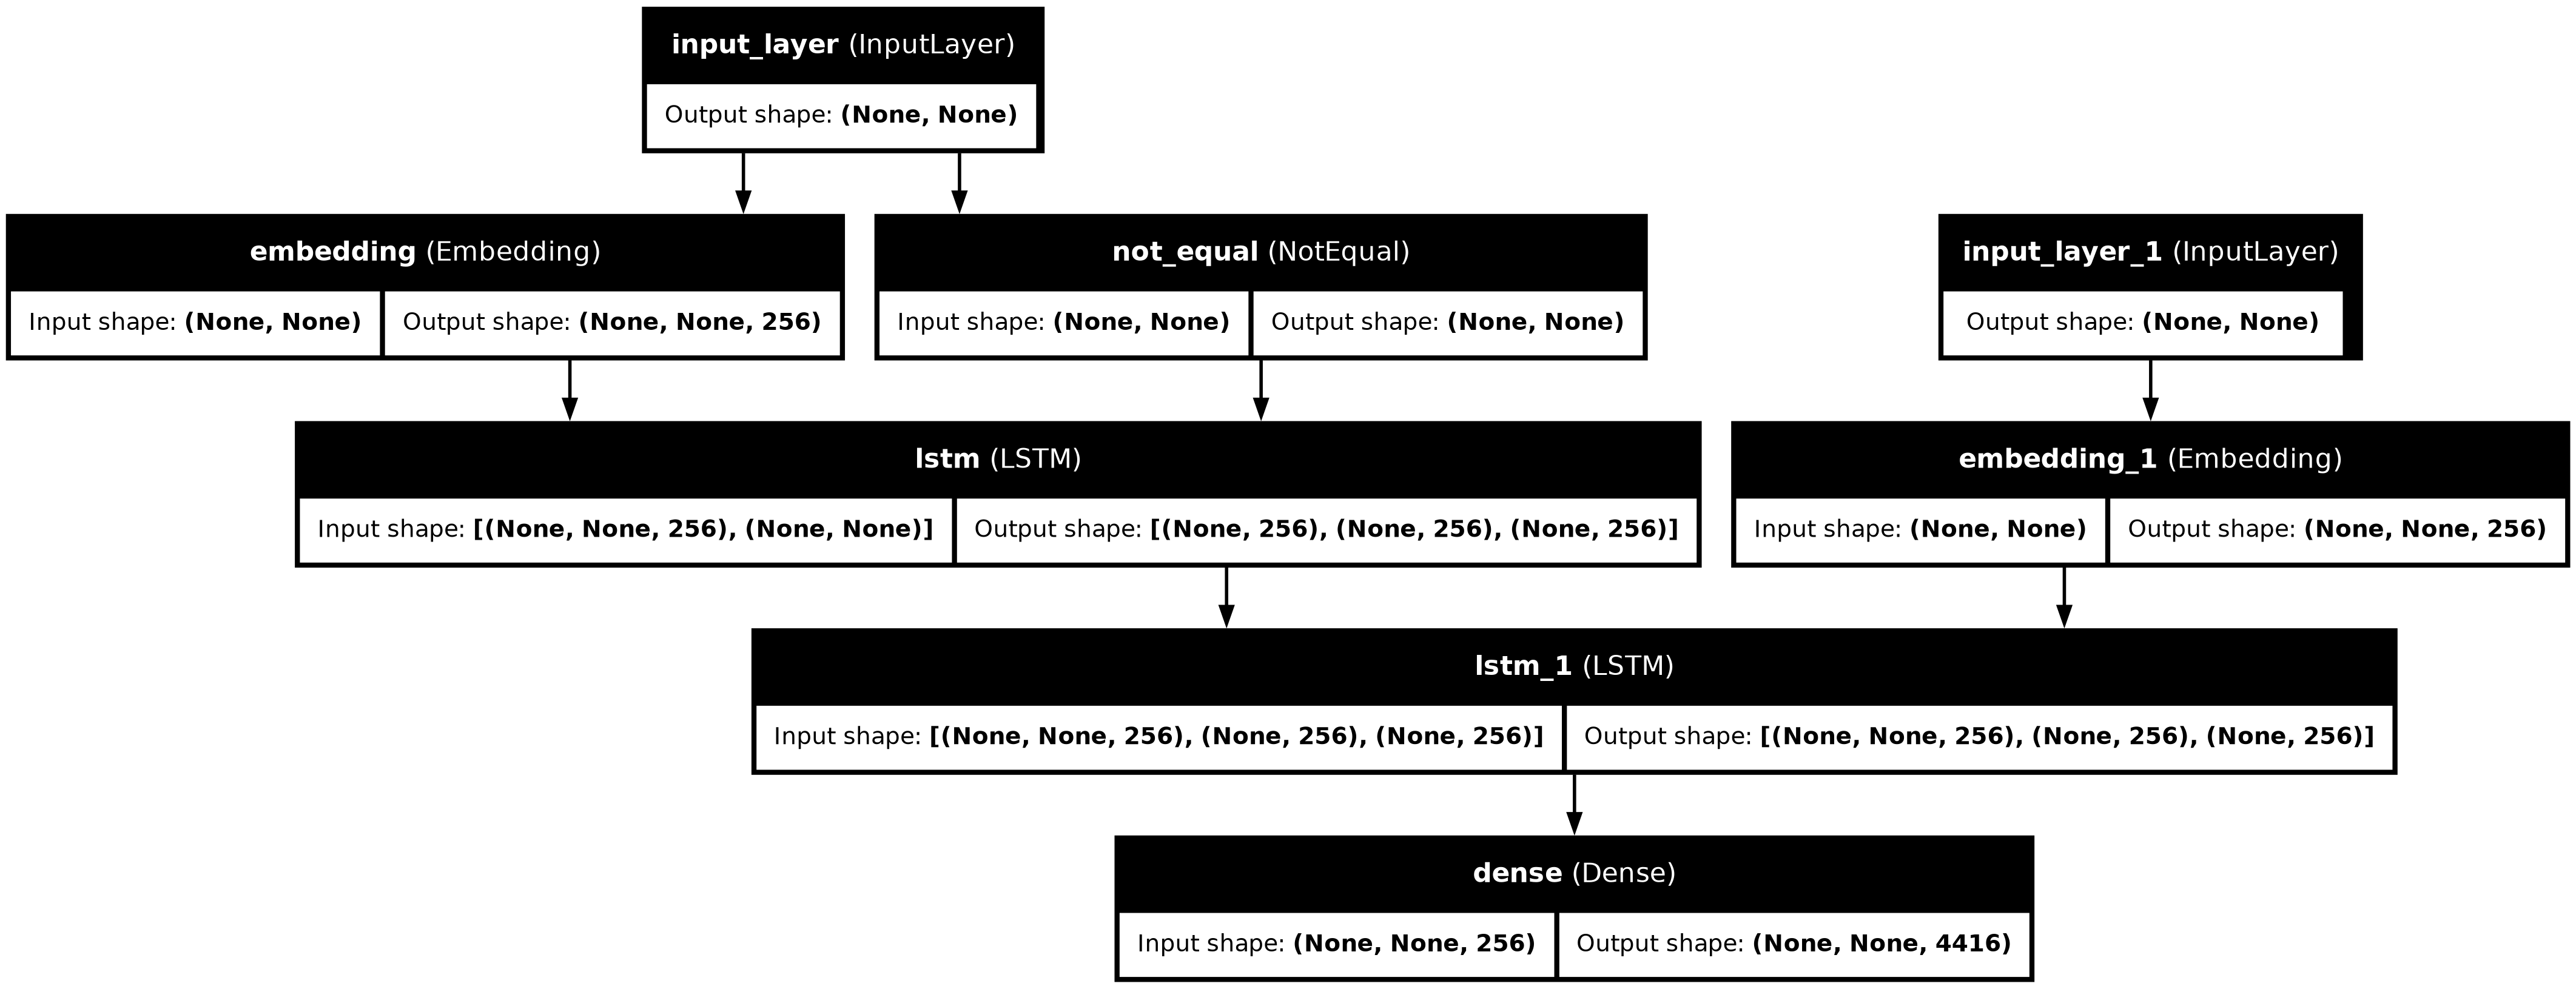

In [21]:
emb_sz = 256
model, encoder_model, decoder_model = seq2seq(num_decoder_tokens, num_encoder_tokens, emb_sz, emb_sz)
print(model.summary())
plot_model(model, show_shapes=True, show_layer_names=True)

In [22]:
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=64,
          epochs=5,
          validation_split=0.2)

Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 64s 484ms/step - acc: 0.5248 - loss: 6.1743 - val_acc: 0.1362 - val_loss: 4.1582
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 80s 471ms/step - acc: 0.1387 - loss: 3.8616 - val_acc: 0.1415 - val_loss: 3.9939
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 59s 469ms/step - acc: 0.1419 - loss: 3.6516 - val_acc: 0.1530 - val_loss: 3.8262
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 58s 464ms/step - acc: 0.1475 - loss: 3.4852 - val_acc: 0.1566 - val_loss: 3.6887
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 83s 473ms/step - acc: 0.1526 - loss: 3.3167 - val_acc: 0.1603 - val_loss: 3.5791


# **Inference**
---

In [23]:
def decode_sequence(input_seq, sep=' '):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index[st_tok]

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_tok = reverse_target_tok_index[sampled_token_index]
        decoded_sentence += sep + sampled_tok

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_tok == end_tok or
           len(decoded_sentence) > 52):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    return decoded_sentence

#### Look at the some translations

In [24]:
for seq_index in range(15):
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', lines.input[seq_index: seq_index + 1])
    print('Decoded sentence:', decoded_sentence)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
-
Input sentence: 0    go
Name: input, dtype: object
Decoded sentence:  soyez _END
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
-
Input sentence: 1    go
Name: input, dtype: object
Decoded sentence:  soyez _END
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
-
Input sentence: 2    go
Name: input, dtype: object
Decoded sentence:  soyez _END
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
-
Input sentence: 3    go
Name: input, dtype: object
Decoded sentence:  soyez _END
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
-
Input sentence: 4    hi
Name: input, dtype: object
Decoded sentence:  cest _END
1/1 ━━━━━━━━━━